## Retrieve MTBS by state from Source coop to test Dask and Docker
For more information: https://source.coop/repositories/cboettig/fire/description

In [1]:
# Import necessary functions 
from utils.source_coop_utils import initialize_dask_cluster,get_usgs_data,get_mtbs_shp,create_wildfire_severity_map
import matplotlib.pyplot as plt
import os
import boto3
from dotenv import load_dotenv

### Initialize a Dask cluster for distributed computing

This helps in handling large datasets and parallel computation efficiently.

In [2]:
# Example usage
client = initialize_dask_cluster()

Dask Dashboard is available at: http://127.0.0.1:8787/status


### Retrieve the AWS Access Key ID and AWS Secret Access Key from the environment variables.

AWS_ACCESS_KEY_ID = "Your AWS_ACCESS_KEY_ID Here "

AWS_SECRET_ACCESS_KEY = "Your AWS_ACCESS_KEY_ID Here")

In [3]:
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")#  replace AWS_ACCESS_KEY_ID with your access key 
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")#  replace AWS_SECRET_ACCESS_KEY with your access key 

In [ ]:
# Checking AWS Key 
AWS_ACCESS_KEY_ID

### Create an S3 client using the boto3 library with custom authentication and endpoint settings.

In [4]:
s3_client = boto3.client(
    's3',                             # Specify the AWS service: 's3' (Simple Storage Service).
    aws_access_key_id=AWS_ACCESS_KEY_ID,       # Provide the AWS Access Key ID for authentication.
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, # Provide the AWS Secret Access Key for authentication.
    endpoint_url='https://data.source.coop'    # Specify a custom S3-compatible endpoint URL (non-AWS S3 service).
)

### You can skip making new directory if you directory already exists

In [12]:
# creating a new directory
os.makedirs('./datas', exist_ok=True)


### Define a local path where data will be stored or accessed.

In [6]:
local_path = "./data"

In [7]:
# Define the name of the file to be fetched,
file_name= "usgs-mtbs"
# Fetch USGS data using the `get_usgs_data` function.
usgs_ddf = get_usgs_data(file_name, s3_client,local_path)

File not found locally. Downloading from s3...
Download complete.
File not found locally. Downloading from s3...
Download complete.


In [8]:
# Define the name of the file to be fetched,
file_name="mtbs_perims_DD"
# Fetch MTBS (Monitoring Trends in Burn Severity) shapefile data using the `get_mtbs_shp` function.
mtbs_shp_ddf=get_mtbs_shp(file_name, s3_client,local_path)

File not found locally. Downloading from s3...
Download complete.
File not found locally. Downloading from s3...
Download complete.
File not found locally. Downloading from s3...
Download complete.
File not found locally. Downloading from s3...
Download complete.
File not found locally. Downloading from s3...
Download complete.
File not found locally. Downloading from s3...
Download complete.
File not found locally. Downloading from s3...
Download complete.
File not found locally. Downloading from s3...
Download complete.
File not found locally. Downloading from s3...
Download complete.


In [9]:
mtbs_shp_ddf

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,Pre_ID,Post_ID,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,
0,object,object,object,object,int64,object,object,int64,object,object,datetime64[ms],object,object,object,int64,int64,int64,int64,int64,int64,int64,object,geometry
7731,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15462,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23193,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30923,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Create a wildfire severity map using the MTBS shapefile data.

In [10]:
map_object = create_wildfire_severity_map(mtbs_shp_ddf)
map_object

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

### This section filters wildfire incidents, groups them by state, counts the occurrences, and visualizes the results as a bar chart showing the number of wildfires by state.

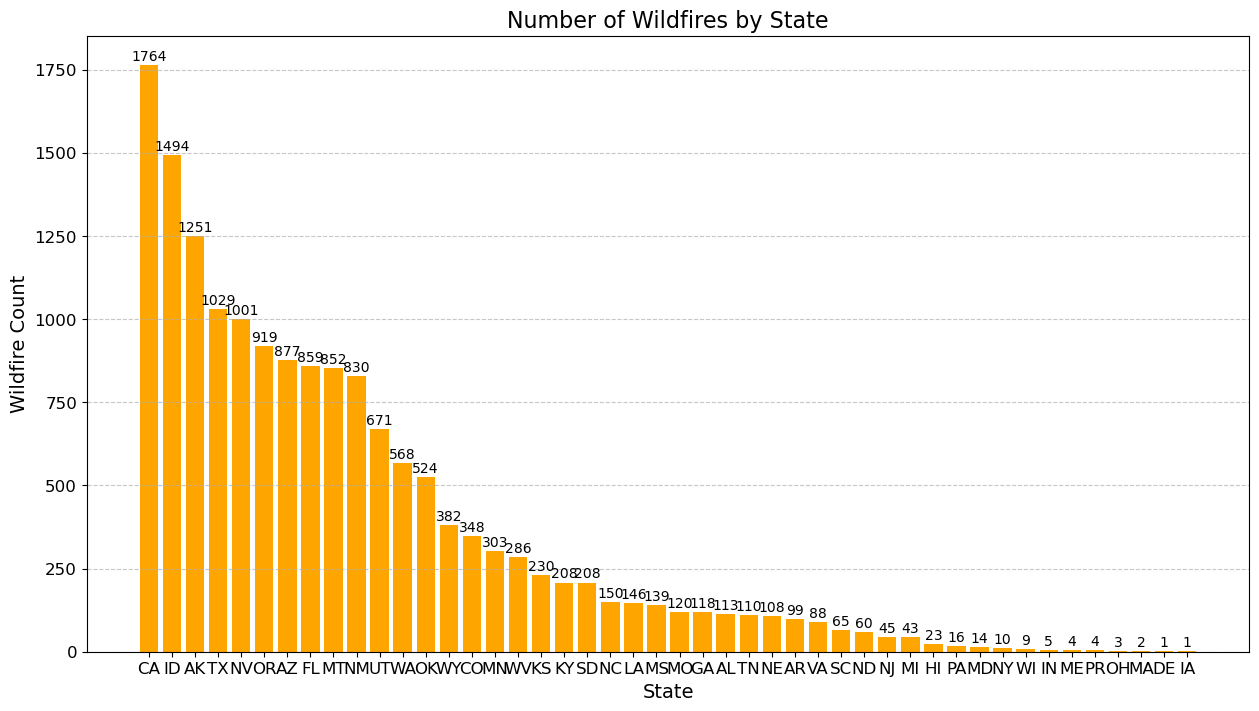

In [11]:
# Filter the data for Wildfire incidents
wildfire_ddf = mtbs_shp_ddf[mtbs_shp_ddf['Incid_Type'] == 'Wildfire']

# Extract state abbreviation from the 'Event_ID' (first two characters)
wildfire_ddf['State'] = wildfire_ddf['Event_ID'].str[:2]

# Group by 'State' and count the number of wildfires
wildfires_by_state = wildfire_ddf.groupby('State').size().compute()

# Convert to a DataFrame for better display
wildfires_by_state_df = wildfires_by_state.reset_index()
wildfires_by_state_df.columns = ['State', 'Wildfire Count']

# Sort the DataFrame by Wildfire Count in descending order
wildfires_by_state_df = wildfires_by_state_df.sort_values(by='Wildfire Count', ascending=False)

# Plot the data as a bar chart
plt.figure(figsize=(15, 8))
plt.bar(wildfires_by_state_df['State'], wildfires_by_state_df['Wildfire Count'], color='orange')

# Add titles and labels
plt.title('Number of Wildfires by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Wildfire Count', fontsize=14)

# Add value labels on top of the bars
for index, value in enumerate(wildfires_by_state_df['Wildfire Count']):
    plt.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()